In [1]:
import tifffile as tiff
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
import SimpleITK as sitk
from skimage.filters import threshold_otsu
from skimage import measure
from scipy.ndimage import minimum_filter

In [2]:
folder_xct = Path(r'E:\temporal\volumenes\32+33+34+35\35')

filename_xct = folder_xct / 'frontal_cropped.tif'

output_folder = folder_xct / 'output'

output_folder.mkdir(exist_ok=True)

xct = tiff.imread(filename_xct)

print(xct.shape)

folder_ut = Path(r'\\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\03_UT_data\Panel PEGASO\Pruebas Pegatinas\doble cara 5\35')

filename_ut = folder_ut / 'aligned.tif'

output_folder.mkdir(exist_ok=True)

ut = tiff.imread(filename_ut)
ut = np.swapaxes(ut, 0, 1)
ut = np.swapaxes(ut, 1, 2)

print(ut.shape)

(300, 3216, 1900)
(151, 59, 506)


In [3]:

def resize_image(original_image, size, show = False):
    width, height = original_image.size
    if show:
        print(f"The original image size is {width} wide x {height} tall")

    resized_image = original_image.resize(size)
    width, height = resized_image.size
    if show:
        print(f"The resized image size is {width} wide x {height} tall")
    return np.array(resized_image)

def calculate_new_dimensions(original_resolution, new_resolution, original_dimensions):
    # Calculate the original dimensions in real-world units
    original_width, original_height = original_dimensions
    real_world_width = original_width * original_resolution
    real_world_height = original_height * original_resolution

    # Calculate the new dimensions in pixels
    new_width = int(real_world_width / new_resolution)
    new_height = int(real_world_height / new_resolution)

    return new_width, new_height

def get_brightest(d):
    data = d.copy()
    #turn to 0 the values below 255
    data[data < 255] = 0
    #calculate the max of each image
    max_values = np.sum(data, axis=(1, 2))
    
    return np.argmax(max_values)



In [4]:
def plot_images(images, figsz = (5, 5)):
    fig, axs = plt.subplots(1, len(images), figsize=figsz)
    for i, img in enumerate(images):
        axs[i].imshow(img, cmap='gray')
        axs[i].axis('off')
    plt.show()

def circles(img):
    # Convert binary image to grayscale
    img = (img * 255).astype(np.uint8)

    # Find contours
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty image to draw circles on
    circle_img = np.zeros_like(img)

    # For each contour
    for contour in contours:
        # Find minimum enclosing circle
        (x, y), radius = cv2.minEnclosingCircle(contour)
        # Draw the circle
        cv2.circle(circle_img, (int(x), int(y)), int(radius), (255, 255, 255), -1)

        break

    return circle_img

def rectangles(img, thickness=2):
    # Convert binary image to grayscale
    img = (img * 255).astype(np.uint8)

    # Find contours
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty image to draw rectangles on
    rectangle_img = np.zeros_like(img)

    # For each contour
    for contour in contours:
        # Find bounding rectangle
        x, y, w, h = cv2.boundingRect(contour)
        # Draw the rectangle contour
        cv2.rectangle(rectangle_img, (x, y), (x+w, y+h), (255, 255, 255), thickness)

    return rectangle_img > 0

import cv2
import numpy as np

def draw_bounding_box(image):

    # Convert binary image to grayscale
    image = (image * 255).astype(np.uint8)

    # Create a new binary image of the same size
    output_image = np.zeros_like(image)

    # Find contours in the image
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # For each contour, draw the bounding box on the new image
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(output_image, (x, y), (x+w, y+h), (255), -1)

    return output_image > 0

def find_rectangle_centers(image):
    # Ensure the image is binary
    assert np.array_equal(image, image.astype(bool)), "Image must be binary"

    # Find connected components in the image
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(image.astype('uint8'))

    # The first component is the background, so ignore it
    return centroids[1:]

def paint_points_on_image(points, image):
    # Create a copy of the image to avoid modifying the original
    image_copy = np.copy(image)

    # Convert the image to RGB if it's grayscale
    if len(image_copy.shape) == 2:
        image_copy = np.stack((image_copy,)*3, axis=-1)

    # Paint each point in red
    for point in points:
        x, y = point
        image_copy[int(y), int(x)] = [255, 0, 0]  # RGB for red

    return image_copy

def find_local_minima(image, size=3, threshold=50):
    # Apply the minimum filter
    filtered_image = minimum_filter(image, size)

    # Find local minima
    local_minima = image == filtered_image

    # Apply threshold
    local_minima = np.logical_and(local_minima, image <= threshold)

    # The result is a boolean mask where True indicates local minima
    return local_minima

def find_brightest_ut(volume):
    # Find the brightest slice
    brightest_slice = np.argmax(np.sum(volume, axis=(0, 1)))

    return brightest_slice

def paint_binary_points(shape, points):
    # Create an empty image of the specified shape
    image = np.zeros(shape, dtype=np.uint8)

    # Iterate over the points
    for point in points:
        # Round the coordinates to the nearest integer
        y,x = tuple(int(round(coord)) for coord in point)
        # cv2.circle(image, (y,x), 5, (255), -1)
        # Draw the point on the image
        image[x,y] = 255

    return image.astype(np.uint8)

In [5]:
aligned_point = find_brightest_ut(ut)
original_resolution = 0.022
new_resolution = 1
print(aligned_point)
gate1 = (aligned_point, aligned_point+1)

144


The new dimensions are (41, 70)
(300, 70, 41)
133


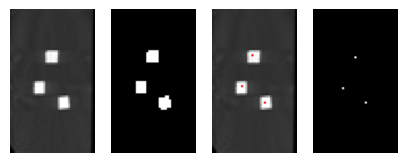

In [6]:

id = get_brightest(xct)

original_dimensions = (xct.shape[2], xct.shape[1])
new_dimensions = calculate_new_dimensions(original_resolution, new_resolution, original_dimensions)
print(f"The new dimensions are {new_dimensions}")
resized = resize_image(Image.fromarray(xct[id]), new_dimensions)

#resized the whole volume
resized_xct = np.zeros((xct.shape[0], new_dimensions[1], new_dimensions[0]), dtype=np.uint8)
for i, img in enumerate(xct):
    resized_xct[i] = resize_image(Image.fromarray(img), new_dimensions)

print(resized_xct.shape)

thresh = threshold_otsu(resized)

print(thresh)

thresholded = resized > thresh

xct_centers  = find_rectangle_centers(thresholded)

centers_painted_xct = paint_binary_points(thresholded.shape, xct_centers)

plot_images([resized, thresholded, paint_points_on_image(xct_centers, resized), centers_painted_xct])

43


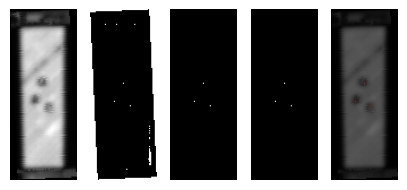

C:\Users\alberto.vicente\AppData\Local\Temp\ipykernel_17772\2822389279.py:28: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(output_folder / 'max_projection_centers.tif', max_projection_centers)


In [7]:
#get the gates
gated_data = ut[:,:,gate1[0]:gate1[1]].reshape(ut.shape[0], ut.shape[1])

#otsu threshold
thresh = threshold_otsu(gated_data)

#create a mask
thresholded = gated_data > thresh

thresholded = ndimage.binary_fill_holes(thresholded)

print(thresh)

minimums = find_local_minima(gated_data, 10)

only_minimus = minimums * thresholded

centers = find_rectangle_centers(only_minimus)

centers_painted_ut = paint_binary_points(gated_data.shape, centers)

#paint the centers in the max projection
max_projection_centers = paint_points_on_image(centers, gated_data)

plot_images([gated_data, minimums, only_minimus, centers_painted_ut, max_projection_centers])

#save the max projection with the centers
tiff.imsave(output_folder / 'max_projection_centers.tif', max_projection_centers)

In [8]:
fixed_image = sitk.GetImageFromArray(centers_painted_ut)
moving_image = sitk.GetImageFromArray(centers_painted_xct)

# Initial alignment of the two volumes
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                    moving_image, 
                                                    sitk.Euler2DTransform(), 
                                                    sitk.CenteredTransformInitializerFilter.GEOMETRY)

# Set up the registration framework
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings
registration_method.SetMetricAsMattesMutualInformation()

# Interpolator
registration_method.SetInterpolator(sitk.sitkLinear)

# # Optimizer settings
# registration_method.SetOptimizerAsRegularStepGradientDescent(learningRate=1.0, minStep=1e-5, numberOfIterations=5000, relaxationFactor=0.5, gradientMagnitudeTolerance=1e-8, estimateLearningRate=registration_method.EachIteration)
# registration_method.SetOptimizerScalesFromPhysicalShift()

# Optimizer settings
registration_method.SetOptimizerAsExhaustive(numberOfSteps=[4,4,4], stepLength = 1.0)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4, 2, 1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas = [2, 1, 0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times
registration_method.SetInitialTransform(initial_transform, inPlace=False)


In [9]:

final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                                            sitk.Cast(moving_image, sitk.sitkFloat32))

In [10]:
# Now, apply the transform to the top volume overlaping reggion
resampler = sitk.ResampleImageFilter()
resampler.SetTransform(final_transform)
resampler.SetDefaultPixelValue(0)  

# Set the properties of the resampler to match the original top volume
resampler.SetOutputSpacing(fixed_image.GetSpacing())
resampler.SetSize(fixed_image.GetSize())
resampler.SetOutputDirection(fixed_image.GetDirection())
resampler.SetOutputOrigin(fixed_image.GetOrigin())
resampler.SetDefaultPixelValue(fixed_image.GetPixelIDValue())

# Apply the transformation
registered = resampler.Execute(moving_image)

resized_registered = resampler.Execute(sitk.GetImageFromArray(resized))

#resized the whole volume
registered_volume = np.zeros((resized_xct.shape[0],centers_painted_ut.shape[0], centers_painted_ut.shape[1]), dtype=np.uint8)
print(registered_volume.shape)
for i, img in enumerate(resized_xct):
    a = resampler.Execute(sitk.GetImageFromArray(resized_xct[i]))
    a = sitk.GetArrayFromImage(a)
    registered_volume[i] = a

(300, 151, 59)


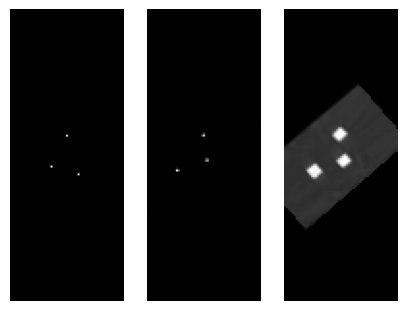

In [11]:
plot_images([sitk.GetArrayFromImage(fixed_image),sitk.GetArrayFromImage(registered),sitk.GetArrayFromImage(resized_registered)])

In [12]:
#save the fixed image
tiff.imsave(output_folder / 'fixed.tif', sitk.GetArrayFromImage(fixed_image))
#save the registered image
tiff.imsave(output_folder / 'registered.tif', sitk.GetArrayFromImage(registered))
#save the resized registered image
tiff.imsave(output_folder / 'resized_registered.tif', sitk.GetArrayFromImage(resized_registered))
#save the registered volume
tiff.imsave(output_folder / 'registered_volume.tif', registered_volume)

C:\Users\alberto.vicente\AppData\Local\Temp\ipykernel_17772\436565323.py:2: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(output_folder / 'fixed.tif', sitk.GetArrayFromImage(fixed_image))
C:\Users\alberto.vicente\AppData\Local\Temp\ipykernel_17772\436565323.py:4: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(output_folder / 'registered.tif', sitk.GetArrayFromImage(registered))
C:\Users\alberto.vicente\AppData\Local\Temp\ipykernel_17772\436565323.py:6: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(output_folder / 'resized_registered.tif', sitk.GetArrayFromImage(resized_registered))
C:\Users\alberto.vicente\AppData\Local\Temp\ipykernel_17772\436565323.py:8: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(output_folder / 'registered_volume.tif', registered_volume)


Mañana tienes que leer lo del correo de Fede.
Despues probar la robustez de los cuadrados.
Despues hacer lo de el punto medio en vez del local minima porque pinta que eso no va a funcionar